In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import json
import shapely
import geopandas as gpd
import networkx as nx
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

In [19]:
stations = pd.read_csv("./subway_stations.csv")
def remove_shuttle(s):
    if "S" in s["Daytime Routes"] and s["Borough"] != "Bk":
        return s["Daytime Routes"].replace("S", "")
    return s["Daytime Routes"]
stations["Daytime Routes"] = stations.apply(remove_shuttle, axis=1)
stations.head()

,GTFS Stop ID,Station ID,Complex ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,ADA,ADA Northbound,ADA Southbound,ADA Notes,Georeference
0,R01,1,1,BMT,Astoria,Astoria-Ditmars Blvd,Q,N W,Elevated,40.775036,-73.912034,Last Stop,Manhattan,0,0,0,NaN,POINT (-73.912034 40.775036)
1,R03,2,2,BMT,Astoria,Astoria Blvd,Q,N W,Elevated,40.770258,-73.917843,Astoria,Manhattan,1,1,1,NaN,POINT (-73.917843 40.770258)
2,R04,3,3,BMT,Astoria,30 Av,Q,N W,Elevated,40.766779,-73.921479,Astoria,Manhattan,0,0,0,NaN,POINT (-73.921479 40.766779)
3,R05,4,4,BMT,Astoria,Broadway,Q,N W,Elevated,40.761820,-73.925508,Astoria,Manhattan,0,0,0,NaN,POINT (-73.925508 40.76182)
4,R06,5,5,BMT,Astoria,36 Av,Q,N W,Elevated,40.756804,-73.929575,Astoria,Manhattan,0,0,0,NaN,POINT (-73.929575 40.756804)


In [20]:
neighborhoods = gpd.read_file('2020_NTA.geojson')
neighborhoods = neighborhoods[neighborhoods['boroname'] != "Staten Island"]
neighborhoods.head()

,shape_area,ntaname,cdtaname,shape_leng,boroname,ntatype,nta2020,borocode,countyfips,ntaabbrev,cdta2020,geometry
0,35321206.58,Greenpoint,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28912.5661127,Brooklyn,0,BK0101,3,047,Grnpt,BK01,"MULTIPOLYGON (((-73.93213 40.72816, -73.93238 ..."
1,28854314.2319,Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28098.0270184,Brooklyn,0,BK0102,3,047,Wllmsbrg,BK01,"MULTIPOLYGON (((-73.96176 40.72523, -73.96154 ..."
2,15208960.6551,South Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),18250.2802623,Brooklyn,0,BK0103,3,047,SWllmsbrg,BK01,"MULTIPOLYGON (((-73.95024 40.70547, -73.94984 ..."
3,52266211.1496,East Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),43184.7728149,Brooklyn,0,BK0104,3,047,EWllmsbrg,BK01,"MULTIPOLYGON (((-73.92406 40.71411, -73.92404 ..."
4,9982321.61811,Brooklyn Heights,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,14312.5049112,Brooklyn,0,BK0201,3,047,BkHts,BK02,"MULTIPOLYGON (((-73.99236 40.68969, -73.99436 ..."


In [21]:
def stations_in_neighborhood(neighborhood):
    def station_in_neighborhood(station):
        return neighborhood['geometry'].contains(shapely.Point(station['GTFS Longitude'], station['GTFS Latitude']))
    return stations[stations.apply(station_in_neighborhood, axis=1)]

def num_stations_in_neighborhood(neighborhood):
    n_stations = len(stations_in_neighborhood(neighborhood))
    return n_stations if n_stations > 0 else None

def lines_in_neighborhood(neighborhood):
    neighborhood_stations = stations_in_neighborhood(neighborhood)
    lines = set()
    for _, station in neighborhood_stations.iterrows():
        for line in station['Daytime Routes'].split():
            lines.add(line)
    return list(lines)

def num_lines_in_neighborhood(neighborhood):
    lines = lines_in_neighborhood(neighborhood)
    return len(lines) if len(lines) > 0 else None

In [22]:
neighborhoods['num_subway_lines'] = neighborhoods.apply(num_lines_in_neighborhood, axis=1)
neighborhoods['num_subway_stations'] = neighborhoods.apply(num_stations_in_neighborhood, axis=1)
neighborhoods.head()

,shape_area,ntaname,cdtaname,shape_leng,boroname,ntatype,nta2020,borocode,countyfips,ntaabbrev,cdta2020,geometry,num_subway_lines,num_subway_stations
0,35321206.58,Greenpoint,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28912.5661127,Brooklyn,0,BK0101,3,047,Grnpt,BK01,"MULTIPOLYGON (((-73.93213 40.72816, -73.93238 ...",1.0,2.0
1,28854314.2319,Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28098.0270184,Brooklyn,0,BK0102,3,047,Wllmsbrg,BK01,"MULTIPOLYGON (((-73.96176 40.72523, -73.96154 ...",2.0,3.0
2,15208960.6551,South Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),18250.2802623,Brooklyn,0,BK0103,3,047,SWllmsbrg,BK01,"MULTIPOLYGON (((-73.95024 40.70547, -73.94984 ...",4.0,3.0
3,52266211.1496,East Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),43184.7728149,Brooklyn,0,BK0104,3,047,EWllmsbrg,BK01,"MULTIPOLYGON (((-73.92406 40.71411, -73.92404 ...",4.0,6.0
4,9982321.61811,Brooklyn Heights,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,14312.5049112,Brooklyn,0,BK0201,3,047,BkHts,BK02,"MULTIPOLYGON (((-73.99236 40.68969, -73.99436 ...",5.0,3.0


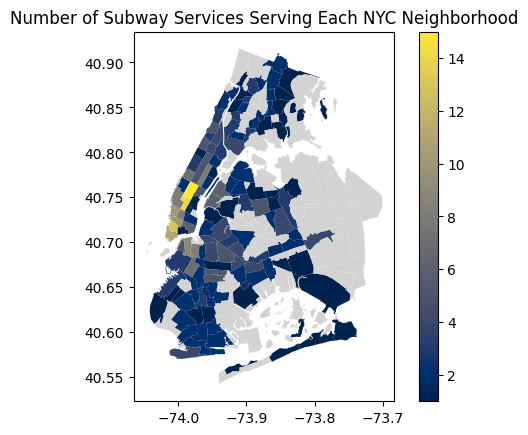

In [52]:
neighborhoods.plot(column='num_subway_lines',
                   cmap='cividis',
                   legend=True,
                   missing_kwds={'color': 'lightgrey'})
plt.title('Number of Subway Services Serving Each NYC Neighborhood')
plt.show()

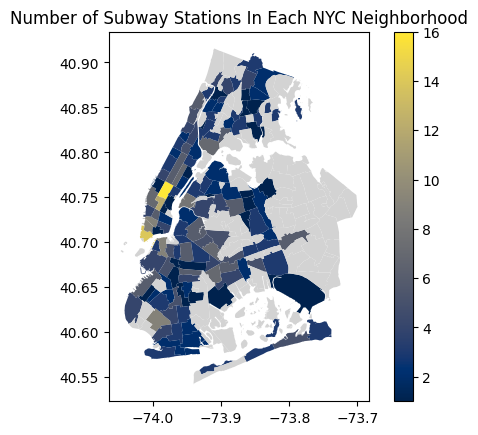

In [53]:
neighborhoods.plot(column='num_subway_stations',
                   cmap='cividis',
                   legend=True,
                   missing_kwds={'color': 'lightgrey'})
plt.title('Number of Subway Stations In Each NYC Neighborhood')
plt.show()

In [25]:
filtered_neighborhoods = neighborhoods[neighborhoods['num_subway_stations'] > 0]
len(neighborhoods), len(filtered_neighborhoods)

(239, 132)

In [43]:
lines = set()
complexes = defaultdict(lambda: set())
for _, row in stations.iterrows():
    for route in row['Daytime Routes'].split():
        complexes[row['Complex ID']].add(route)
        lines.add(route)
for k in [x for x in complexes]:
    if len(complexes[k]) < 2:
        del complexes[k]

In [45]:
transfers = defaultdict(lambda: set())
for l1 in lines:
    for c in complexes.values():
        if l1 in c:
            for l2 in c:
                if l2 != l1:
                    transfers[l1].add(l2)
                    transfers[l2].add(l1)

In [46]:
def get_single_seat_graph():
    graph = nx.DiGraph()
    for _, row in filtered_neighborhoods.iterrows():
        lines = lines_in_neighborhood(row)
        for line in lines:
            graph.add_edge(row['ntaname'] + "-Source", line, weight=0)
            graph.add_edge(line, row['ntaname'], weight=0)
    return graph

def get_transfer_graph():
    graph = get_single_seat_graph()
    for a, bs in transfers.items():
        for b in bs:
            graph.add_edge(a, b, weight=1)
    return graph

neighborhood_names = set(filtered_neighborhoods['ntaname'])

def reachable(source, graph):
    if not graph.has_node(source):
        return set()
    reachable_nodes = set(nx.descendants(graph, source + "-Source"))
    valid_reachable = neighborhood_names.intersection(reachable_nodes)
    if source in valid_reachable:
        valid_reachable.remove(source)
    return valid_reachable

def num_reachable(source, graph):
    reachable_neighborhoods = reachable(source, graph)
    return len(reachable_neighborhoods) if len(reachable_neighborhoods) > 0 else None

def reachable_cost(source, graph, max_cost):
    if not graph.has_node(source):
        return set()
    dijkstra = nx.single_source_dijkstra_path_length(graph, source + "-Source", weight='weight')
    reachable_nodes = set([node for node, cost in dijkstra.items() if cost <= max_cost])
    valid_reachable = neighborhood_names.intersection(reachable_nodes)
    if source in valid_reachable:
        valid_reachable.remove(source)
    return valid_reachable

def num_reachable_cost(source, graph, max_cost):
    reachable_neighborhoods = reachable_cost(source, graph, max_cost)
    return len(reachable_neighborhoods) if len(reachable_neighborhoods) > 0 else None

In [47]:
single_seat = get_single_seat_graph()
transfer = get_transfer_graph()

In [48]:
neighborhoods['single_seat_reachable'] = neighborhoods.apply(lambda x: num_reachable(x['ntaname'], single_seat), axis=1)
neighborhoods['one_transfer_reachable'] = neighborhoods.apply(lambda x: num_reachable_cost(x['ntaname'], transfer, 1), axis=1)
neighborhoods['two_transfer_reachable'] = neighborhoods.apply(lambda x: num_reachable_cost(x['ntaname'], transfer, 2), axis=1)
neighborhoods.head()

,shape_area,ntaname,cdtaname,shape_leng,boroname,ntatype,nta2020,borocode,countyfips,ntaabbrev,cdta2020,geometry,num_subway_lines,num_subway_stations,single_seat_reachable,one_transfer_reachable,two_transfer_reachable
0,35321206.58,Greenpoint,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28912.5661127,Brooklyn,0,BK0101,3,047,Grnpt,BK01,"MULTIPOLYGON (((-73.93213 40.72816, -73.93238 ...",1.0,2.0,12.0,78.0,131.0
1,28854314.2319,Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28098.0270184,Brooklyn,0,BK0102,3,047,Wllmsbrg,BK01,"MULTIPOLYGON (((-73.96176 40.72523, -73.96154 ...",2.0,3.0,24.0,128.0,131.0
2,15208960.6551,South Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),18250.2802623,Brooklyn,0,BK0103,3,047,SWllmsbrg,BK01,"MULTIPOLYGON (((-73.95024 40.70547, -73.94984 ...",4.0,3.0,39.0,130.0,131.0
3,52266211.1496,East Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),43184.7728149,Brooklyn,0,BK0104,3,047,EWllmsbrg,BK01,"MULTIPOLYGON (((-73.92406 40.71411, -73.92404 ...",4.0,6.0,44.0,130.0,131.0
4,9982321.61811,Brooklyn Heights,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,14312.5049112,Brooklyn,0,BK0201,3,047,BkHts,BK02,"MULTIPOLYGON (((-73.99236 40.68969, -73.99436 ...",5.0,3.0,56.0,131.0,131.0


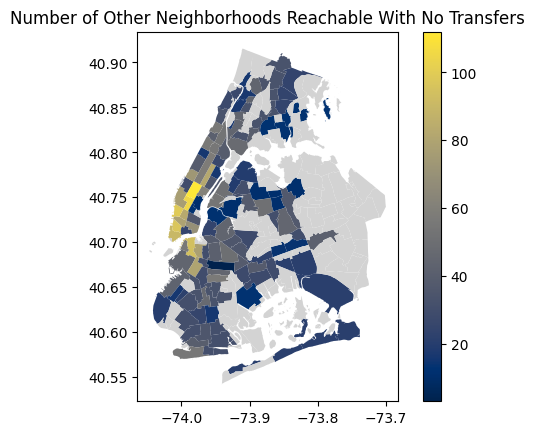

In [54]:
neighborhoods.plot(column='single_seat_reachable',
                   cmap='cividis',
                   legend=True,
                   missing_kwds={'color': 'lightgrey'})
plt.title('Number of Other Neighborhoods Reachable With No Transfers')
plt.show()

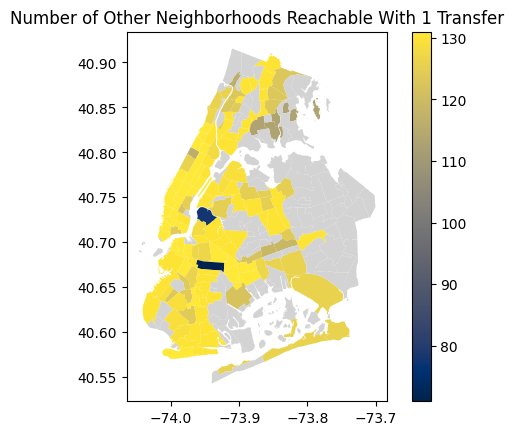

In [55]:
neighborhoods.plot(column='one_transfer_reachable',
                   cmap='cividis',
                   legend=True,
                   missing_kwds={'color': 'lightgrey'})
plt.title('Number of Other Neighborhoods Reachable With 1 Transfer')
plt.show()

In [51]:
json_data = []
for _, n in neighborhoods.iterrows():
    json_data.append({
        "name": n['ntaname'],
        "single_seat": list(reachable(n['ntaname'], single_seat)),
        "one_transfer": list(reachable_cost(n['ntaname'], transfer, 1)),
        "stations": list(stations_in_neighborhood(n)['Station ID']),
        "services": list(lines_in_neighborhood(n))
    })
import json
with open("./processed_data.json", "w") as f:
    json.dump(json_data, f, indent=2)